In [1]:
import pandas as pd
import mlflow
import mlflow.sklearn
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix
import numpy as np
import subprocess
import json
import os

import boto3
import mlflow.sagemaker as mfs
import json

## Test Run

In [8]:
df = pd.read_csv("./creditcard.csv")

normal = df[df.Class == 0].sample(frac=0.5, random_state=2020).reset_index(drop=True)
anomaly = df[df.Class == 1]
normal_train, normal_test = train_test_split(normal, test_size = 0.2, random_state = 2020)
anomaly_train, anomaly_test = train_test_split(anomaly, test_size = 0.2, random_state = 2020)
scaler = StandardScaler()
scaler.fit(pd.concat((normal, anomaly)).drop(["Time", "Class"], axis=1))

StandardScaler()

## Local Deployment

In [11]:
test = df.iloc[:8000]
true = test.Class
test = scaler.transform(test.drop(["Time", "Class"], axis=1))
preds = []
batch_size = 80
for i in range(100):
    batch = pd.DataFrame(test[i*batch_size:(i+1)*batch_size]).to_json(orient="split")
    proc = subprocess.run(["curl",  "-X", "POST", "-H",
                          "Content-Type:application/json; format=pandas-split", "--data",
                          batch, "http://127.0.0.1:1235/invocations"],
                          stdout=subprocess.PIPE, encoding='utf-8')
    output = proc.stdout
    resp = pd.DataFrame([json.loads(output)])
    preds = np.concatenate((preds, resp.values[0]))
    
eval_acc = accuracy_score(true, preds)
eval_auc = roc_auc_score(true, preds)
print("Eval Acc", eval_acc)
print("Eval AUC", eval_auc)

Eval Acc 0.984625
Eval AUC 0.9922884012539185


Text(0.5, 1.0, 'Confusion Matrix')

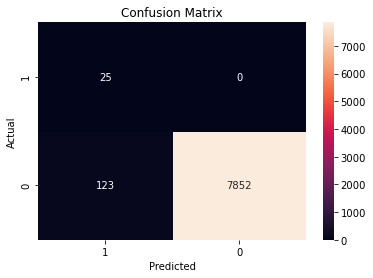

In [12]:
conf_matrix = confusion_matrix(true, preds)
ax = sns.heatmap(conf_matrix, annot=True,fmt='g')
ax.invert_xaxis()
ax.invert_yaxis()
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("Confusion Matrix")

## Deploy to AWS

In [3]:
import subprocess
s3_bucket_name = "fraud-detection-deploy"
mlruns_direc = "./mlruns/"
output = subprocess.run(["aws",  "s3", "sync", "{}".format(mlruns_direc), "s3://{}".format(s3_bucket_name)], stdout=subprocess.PIPE, encoding='utf-8')
print(output.stdout)
print("Saved to bucket: ", s3_bucket_name)

Completed 401 Bytes/255.5 KiB (99 Bytes/s) with 414 file(s) remaining
upload: mlruns\1\468e27197d9e475da6ed8d60ed0666fe\meta.yaml to s3://fraud-detection-deploy/1/468e27197d9e475da6ed8d60ed0666fe/meta.yaml
Completed 401 Bytes/255.5 KiB (99 Bytes/s) with 413 file(s) remaining
Completed 803 Bytes/255.5 KiB (120 Bytes/s) with 413 file(s) remaining
upload: mlruns\1\564f2522e5a74f61941db816390a892e\meta.yaml to s3://fraud-detection-deploy/1/564f2522e5a74f61941db816390a892e/meta.yaml
Completed 803 Bytes/255.5 KiB (120 Bytes/s) with 412 file(s) remaining
Completed 867 Bytes/255.5 KiB (94 Bytes/s) with 412 file(s) remaining 
upload: mlruns\1\564f2522e5a74f61941db816390a892e\tags\mlflow.source.name to s3://fraud-detection-deploy/1/564f2522e5a74f61941db816390a892e/tags/mlflow.source.name
Completed 867 Bytes/255.5 KiB (94 Bytes/s) with 411 file(s) remaining
Completed 872 Bytes/255.5 KiB (81 Bytes/s) with 411 file(s) remaining
Completed 908 Bytes/255.5 KiB (85 Bytes/s) with 411 file(s) remaining
C

In [4]:
# Intialize required parameters

app_name = "fraud-detection"

s3_bucket_name = "fraud-detection-deploy"
experiment_id = "1"
run_id = "468e27197d9e475da6ed8d60ed0666fe"
model_name = "log_model"
model_uri = "s3://{}/{}/{}/artifacts/{}/".format(s3_bucket_name, experiment_id, run_id, model_name)

#execution_role_arn ="arn:aws:iam::249158329839:role/service-role/AmazonSageMaker-ExecutionRole-20210129T102048" 
execution_role_arn ="arn:aws:iam::287359593969:role/sagemaker"

region = "eu-west-2"

image_ecr_url = "287359593969.dkr.ecr.eu-west-2.amazonaws.com/mlflow-pyfunc:1.17.0"

In [5]:
mfs.deploy(app_name=app_name,
           model_uri=model_uri,
           execution_role_arn=execution_role_arn,
           region_name=region,
           image_url=image_ecr_url,
           mode=mfs.DEPLOYMENT_MODE_CREATE)

2021/06/13 20:47:42 INFO mlflow.sagemaker: Using the python_function flavor for deployment!
2021/06/13 20:47:42 INFO mlflow.sagemaker: No model data bucket specified, using the default bucket
2021/06/13 20:47:43 INFO mlflow.sagemaker: Default bucket `mlflow-sagemaker-eu-west-2-287359593969` not found. Creating...
2021/06/13 20:47:43 INFO mlflow.sagemaker: Bucket creation response: {'ResponseMetadata': {'RequestId': 'XB6EN12YE74X131Q', 'HostId': 'ZEVN+vymlPXOUpFJims5vxKsuM3IBDuVUE4MvGNbqeCfqK4CmhxmxRhOMT1Kn2bM4WrlXSe65Ts=', 'HTTPStatusCode': 200, 'HTTPHeaders': {'x-amz-id-2': 'ZEVN+vymlPXOUpFJims5vxKsuM3IBDuVUE4MvGNbqeCfqK4CmhxmxRhOMT1Kn2bM4WrlXSe65Ts=', 'x-amz-request-id': 'XB6EN12YE74X131Q', 'date': 'Sun, 13 Jun 2021 18:47:44 GMT', 'location': 'http://mlflow-sagemaker-eu-west-2-287359593969.s3.amazonaws.com/', 'content-length': '0', 'server': 'AmazonS3'}, 'RetryAttempts': 0}, 'Location': 'http://mlflow-sagemaker-eu-west-2-287359593969.s3.amazonaws.com/'}
2021/06/13 20:47:44 INFO mlflo

In [16]:
# mfs.delete(app_name=app_name,region_name=region)

In [6]:
def query(input_json):
        client = boto3.session.Session().client("sagemaker-runtime", region)
        response = client.invoke_endpoint(
            EndpointName=app_name,
            Body=input_json,
            ContentType='application/json; format=pandas-split',
        )
        preds = response['Body'].read().decode("ascii")
        preds = json.loads(preds)
        return preds

In [13]:
test = pd.concat((normal.iloc[:1900], anomaly.iloc[:100]))
true = test.Class
test = scaler.transform(test.drop(["Time", "Class"], axis=1))
preds = []
batch_size = 100
for f in range(20):
    sample = pd.DataFrame(test[f*batch_size:(f+1)*batch_size]).to_json(orient="split")
    output = query(sample)
    resp = pd.DataFrame([output])
    preds = np.concatenate((preds, resp.values[0]))
    print(f"Batch {f} - Completed")
eval_acc = accuracy_score(true, preds)
eval_auc = roc_auc_score(true, preds)
print("Eval Acc", eval_acc)
print("Eval AUC", eval_auc)

Batch 0 - Completed
Batch 1 - Completed
Batch 2 - Completed
Batch 3 - Completed
Batch 4 - Completed
Batch 5 - Completed
Batch 6 - Completed
Batch 7 - Completed
Batch 8 - Completed
Batch 9 - Completed
Batch 10 - Completed
Batch 11 - Completed
Batch 12 - Completed
Batch 13 - Completed
Batch 14 - Completed
Batch 15 - Completed
Batch 16 - Completed
Batch 17 - Completed
Batch 18 - Completed
Batch 19 - Completed
Eval Acc 0.9855
Eval AUC 0.9734210526315789
